# Data

For the illustration of the group fairness metrics in TrustyAI, two synthetic datasets were created with the same input features and outcome types. 
The outcome is whether a certain invidual reaches a 50k income threshold by using age, race and gender as categorical inputs and both datasets consist of $N=10000$ data points.
The gender values are allocated with a proportion of 20% to `gender=0` and 80% to `gender=1`.

Both datasets have an increasing likelihood (with uniform probability) of having a positive outcome with age, regardless of race or gender.
The first dataset, deemed _unbiased_, simply allocates the income value with an uniform random value, regardless of race or gender.
The second dataset, deemed _biased_, allocates a positive outcome to `gender=0` with a lower probability than `gender=1`.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/income-unbiased.zip", index_col=False)

In [3]:
df

,age,race,gender,income
0,13,0,0,0
1,65,7,0,1
2,71,6,1,0
3,38,1,1,1
4,42,0,0,1
...,...,...,...,...
9995,20,5,1,0
9996,34,2,1,0
9997,25,2,1,1
9998,73,5,1,1


# Demographic Parity


_Demographic Parity_ provides a measure of imbalances in positive and negative outcomes between priveleged and unprivileged groups.

Taking the previous data as an example, we would use Demographic Parity metrics to measure if (for instance), the `income` is predicted to be above or below $50k regardless of race or gender.


## Statistical Parity Difference

The _Statistical Parity Difference (SPD)_  is the difference in the probability of prediction between the privileged and unprivileged groups. Typically:

- $SPD=0$ means that the model is behaving fairly in regards of the selected attribute (e.g. race, gender)
- Values between $-0.1<SPD<0.1$ mean that the model is _reasonably fair_ and the score can be attributed to other factors, such as sample size.
- An $SPD$ outside this range would be an indicator of an _unfair_ model relatively to the protected attributes.
    - A *negative* value of statistical parity difference indicates that the unprivileged group is at a disadvantage
    - A *positive* value indicates that the privileged group is at a disadvantage.

The formal definition of $SPD$ is

$$
SPD=p(\hat{y}=1|\mathcal{D}_u)-p(\hat{y}=1|\mathcal{D}_p)
$$

where $\hat{y}=1$ is the favorable outcome and $\mathcal{D}_u$, $\mathcal{D}_p$ are respectively the privileged and unpriviledge group data.


### Unbiased dataset

In [4]:
nobias = pd.read_csv("data/income-unbiased.zip", index_col=False)
nobias.groupby(['gender', 'income'])['income'].count()

gender  income
0       0         1466
        1          548
1       0         5842
        1         2144
Name: income, dtype: int64

<AxesSubplot: xlabel='gender'>

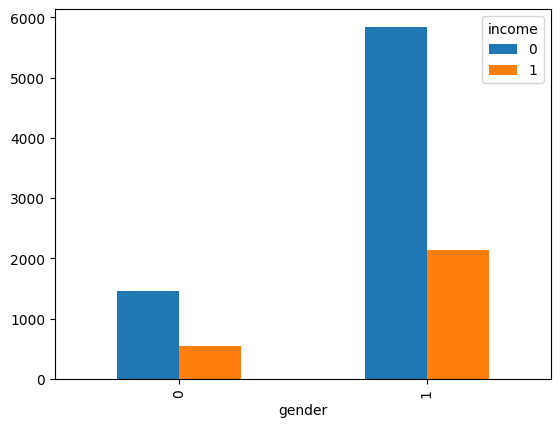

In [5]:
nobias.groupby(['gender', 'income'])['income'].count().unstack().plot.bar()

In [6]:
from trustyai.metrics.fairness.group import statistical_parity_difference
from trustyai.model import output

nobias_privileged = nobias[nobias.gender == 1]
nobias_unprivileged = nobias[nobias.gender == 0]
favorable = output("income", dtype="number", value=1)
score = statistical_parity_difference(privileged=nobias_privileged,
                                      unprivileged=nobias_unprivileged,
                                      favorable=[favorable])

In [7]:
print(score)

0.0036255104824703954


We can see that the $SPD$ for this dataset is between the $[-0.1, 0.1]$ threshold, which classifies the model as _reasonably fair_.

### Biased dataset

In [8]:
bias = pd.read_csv("data/income-biased.zip", index_col=False)
bias.groupby(['gender', 'income'])['income'].count()

gender  income
0       0         1772
        1          242
1       0         5775
        1         2211
Name: income, dtype: int64

<AxesSubplot: xlabel='gender'>

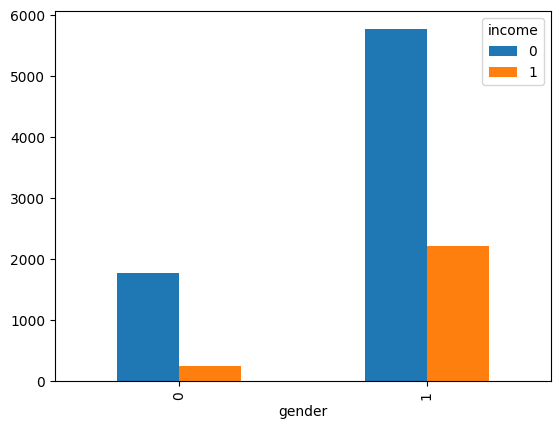

In [9]:
bias.groupby(['gender', 'income'])['income'].count().unstack().plot.bar()

In [10]:
bias_privileged = bias[bias.gender == 1]
bias_unprivileged = bias[bias.gender == 0]

score = statistical_parity_difference(privileged=bias_privileged,
                                      unprivileged=bias_unprivileged,
                                      favorable=[favorable])

In [11]:
print(score)

-0.15670061634672994


This dataset, as expected, is outside the $[-0.1, 0.1]$ threshold, which classifies the model as _unfair_.
In addiction, the negative score indicates that the unprivileged group (in our example, `gender = 0`) is the one in disadvantage for this particular outcome.

## Disparate impact ratio


Similarly to the _Statistical Parity Difference_, the _Disparate Impact Ratio (DIR)_ measures imbalances in positive outcome predictions across privliged and unpriviliged groups.
Instead of calculating the difference, this metric calculates the ration of such selection rates.Typically:

- $DIR=1$ means that the model is fair with regards to the protected attribute.
- $0.8<DIR<1.2$ means that the model is _reasonably fair_.

The formal definition of the _Disparate Impact Ratio_ is:

$$
DIR=\dfrac{p(\hat{y}=1|\mathcal{D}_u)}{p(\hat{y}=1|\mathcal{D}_p)}
$$


In [12]:
from trustyai.metrics.fairness.group import disparate_impact_ratio

score = disparate_impact_ratio(privileged=nobias_privileged,
                               unprivileged=nobias_unprivileged,
                                      favorable=[favorable])

In [13]:
print(score)

1.0135043501459928


As with the $SPD$ we can see that the $DIR$ indicates a reasonably fair model (close to $1$) for the unbiased dataset.

In [14]:
score = disparate_impact_ratio(privileged=bias_privileged,
                               unprivileged=bias_unprivileged,
                            favorable=[favorable])

In [15]:
print(score)

0.43400672901628895


And also, as expected, the $DIR$ indicates a biased model for the biased dataset.

## Average Odds Difference

_Average Odds Difference_ measures the difference between the True Positive Rates ($TPR$) for the privileged and unprivileged groups, and the False Positive Rates ($FPR$) for the same groups. Formally, the definition is:

$$
AOD=\dfrac{(FPR_{u}-FPR_{p})+(TPR_{u}-TPR_{p})}{2}
$$

Typically:

- A fair model will have $AOD=0$
- A positive value indicates the model benefits the unprivileged group
- A negative value indicates the model benefits the privileged group

In [16]:
from trustyai.metrics.fairness.group import average_odds_difference

score = average_odds_difference(test=bias,
                                truth=nobias,
                                privilege_columns=["gender"],
                                privilege_values=[1], # privileged gender value, gender = 1
                                positive_class=[1]) # positive class, income = 1

In [17]:
print(score)

-0.23806418646688987


As we can see, the $AOD$ indicates that the privileged group (`gender = 1`) is at an advantage in this model.

## Average Predictive Value Difference

The _Average Predictive Value Difference (APVD)_ measures the difference in the average accuracy of predicted values between the privileged and unprivileged groups in a dataset. 


In [18]:
from trustyai.metrics.fairness.group import average_predictive_value_difference

score = average_predictive_value_difference(test=bias,
                                truth=nobias,
                                privilege_columns=["gender"],
                                privilege_values=[1],
                                positive_class=[1])
print(score)

-0.04841289822293428


# Models

## Statistical Parity Difference

In [19]:
from xgboost import XGBClassifier


def train(dataset):
  df = pd.read_csv(dataset)

  categories = ['race', 'gender', 'income']
  for f in categories:
      df[f] = df[f].astype('int')
  df['age'] = df['age'].astype('int')

  _X = df[["age", "race", "gender"]]
  _y = df.income

  clf = XGBClassifier(objective="binary:logistic", 
                        use_label_encoder=False,
                        eval_metric='logloss')
  clf.fit(_X, _y)
  return clf

xgb = train("data/income-biased.zip")


/home/rui/.virtualenvs/trustyai-explainability-python-examples/lib/python3.11/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rui/.virtualenvs/trustyai-explainability-python-examples/lib/python3.11/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [20]:
from trustyai.model import Model
from trustyai.metrics.fairness.group import statistical_parity_difference_model

X = nobias[["age", "race", "gender"]]

model = Model(xgb.predict, dataframe_input=True, output_names=["approved"])
score = statistical_parity_difference_model(samples=X,
                                            model=model,
                                            privilege_columns=["gender"],
                                            privilege_values=[1],
                                            favorable=[favorable])
print(score)

-0.06288176602997649


## Disparate impact ratio

In [21]:
from trustyai.metrics.fairness.group import disparate_impact_ratio_model

score = disparate_impact_ratio_model(samples=X,
                                            model=model,
                                            privilege_columns=["gender"],
                                            privilege_values=[1],
                                            favorable=[favorable])
print(score)

0.03798125763334818


## Average Odds Difference

In [22]:
from trustyai.metrics.fairness.group import average_odds_difference_model

score = average_odds_difference_model(samples=X,
                                      model=model,
                                      privilege_columns=["gender"],
                                      privilege_values=[1],
                                      positive_class=[1])
print(score)

9.581224702515101e-14
